# 顧客光顧麵包店的消費選擇

資料來源: [Kaggle](https://www.kaggle.com/sulmansarwar/transactions-from-a-bakery)

這是一份從2016/10/30-2017/04/09的某間麵包店所有顧客的交易資料  
我們想從中了解顧客的購買偏好、麵包店的銷售狀況、以及產品之間的關聯性

* 欄位說明：  
> Date：交易日期  
> Time：交易時間  
> TransactionID：交易ID  
> Item：購買品項

---

# I 匯入套件

In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

---

# II 檢查資料
> 匯入資料，觀察資料表 (資料型態、資料時間等等)

In [3]:
df = pd.read_csv(r'D:\DataMining\week04\BreadBasket.csv')
display(df.head(),df.shape,df.info()) #資料型態與數目

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21293 entries, 0 to 21292
Data columns (total 4 columns):
Date             21293 non-null object
Time             21293 non-null object
TransactionID    21293 non-null int64
Item             21293 non-null object
dtypes: int64(1), object(3)
memory usage: 665.5+ KB


,Date,Time,TransactionID,Item
0,2016/10/30,09:58:11,1,Bread
1,2016/10/30,10:05:34,2,Scandinavian
2,2016/10/30,10:05:34,2,Scandinavian
3,2016/10/30,10:07:57,3,Hot chocolate
4,2016/10/30,10:07:57,3,Jam


(21293, 4)

None

---

# III 資料清整與處理

### 處理缺失值或空值
> 先將Item內容轉為小寫以利後續的資料處理

In [4]:
df['Item'] = df['Item'].str.lower() #全部轉小寫
df.isna().values.any() #檢查空值

False

> 沒有空值，檢查Item內是否有奇怪的項目，再予以刪除  
> 資料簡介有提到Item欄位可能內含有**none(無交易)** 和 **adjustment(交易調整)** 的值，需要刪除

In [5]:
df['Item'].unique() #是否有奇怪的交易項目

array(['bread', 'scandinavian', 'hot chocolate', 'jam', 'cookies',
       'muffin', 'coffee', 'pastry', 'medialuna', 'tea', 'none',
       'tartine', 'basket', 'mineral water', 'farm house', 'fudge',
       'juice', "ella's kitchen pouches", 'victorian sponge', 'frittata',
       'hearty & seasonal', 'soup', 'pick and mix bowls', 'smoothies',
       'cake', 'mighty protein', 'chicken sand', 'coke',
       'my-5 fruit shoot', 'focaccia', 'sandwich', 'alfajores', 'eggs',
       'brownie', 'dulce de leche', 'honey', 'the bart', 'granola',
       'fairy doors', 'empanadas', 'keeping it local', 'art tray',
       'bowl nic pitt', 'bread pudding', 'adjustment', 'truffles',
       'chimichurri oil', 'bacon', 'spread', 'kids biscuit', 'siblings',
       'caramel bites', 'jammie dodgers', 'tiffin', 'olum & polenta',
       'polenta', 'the nomad', 'hack the stack', 'bakewell',
       'lemon and coconut', 'toast', 'scone', 'crepes', 'vegan mincepie',
       'bare popcorn', 'muesli', 'crisps', 'pi

In [6]:
df = df.drop(df[df.Item == 'none'].index) #丟掉空交易
df = df.drop(df[df.Item == 'adjustment'].index) #丟掉調整交易

In [8]:
count = df['Item'].unique()
print("Item的種類數目：",len(count),"\n資料總列數：",df.shape[0],"\n資料總欄數：",df.shape[1]) #檢閱資料

Item的種類數目： 93 
資料總列數： 20506 
資料總欄數： 4


---

### 處理離異值
> 檢查是否有不合理的數值  
> 基本假設店家有固定的營業時間，非營業時間的交易我們不考量在內

### 先依需要將資料欄位拆解或合併

In [9]:
df.head(3) 

,Date,Time,TransactionID,Item
0,2016/10/30,09:58:11,1,bread
1,2016/10/30,10:05:34,2,scandinavian
2,2016/10/30,10:05:34,2,scandinavian


> 將兩欄時間資料合併後轉為時間資料型態，再依**年、月、日、週、星期、小時**拆分，方便後續運算

In [16]:
df['Datetime'] = pd.to_datetime(df['Date']+" "+df['Time'])
df['Year'] = df['Datetime'].dt.year #轉成年
df['Month'] = df['Datetime'].dt.month #轉成月
df['Day'] = df['Datetime'].dt.day #轉成日
df['Week'] = df['Datetime'].dt.week #轉成週
df['Weekday'] = df['Datetime'].dt.weekday #轉成星期
df['Hours'] = df['Datetime'].dt.hour #轉成小時

In [17]:
df=df[['Datetime','TransactionID','Item','Date','Time','Year','Month','Day','Week','Weekday','Hours']]
df.head(5)

,Datetime,TransactionID,Item,Date,Time,Year,Month,Day,Week,Weekday,Hours
0,2016-10-30 09:58:11,1,bread,2016/10/30,09:58:11,2016,10,30,43,6,9
1,2016-10-30 10:05:34,2,scandinavian,2016/10/30,10:05:34,2016,10,30,43,6,10
2,2016-10-30 10:05:34,2,scandinavian,2016/10/30,10:05:34,2016,10,30,43,6,10
3,2016-10-30 10:07:57,3,hot chocolate,2016/10/30,10:07:57,2016,10,30,43,6,10
4,2016-10-30 10:07:57,3,jam,2016/10/30,10:07:57,2016,10,30,43,6,10


### 擷取所需的時間區間

> 觀察最後的交易時間

In [18]:
df.tail(3)

,Datetime,TransactionID,Item,Date,Time,Year,Month,Day,Week,Weekday,Hours
21290,2017-04-09 14:57:06,9683,coffee,2017/4/9,14:57:06,2017,4,9,14,6,14
21291,2017-04-09 14:57:06,9683,pastry,2017/4/9,14:57:06,2017,4,9,14,6,14
21292,2017-04-09 15:04:24,9684,smoothies,2017/4/9,15:04:24,2017,4,9,14,6,15


> 資料時間：2016/10/30 - 2017/4/9  
> 我們希望獲取的資料能夠至少涵蓋完整的月分，故僅取 2016/11/1 - 2017/3/31

In [19]:
cs1 = df[(df.Year == 2016)&(df.Month >= 11)] # 限制式1: 時間開始於 2016/11/1
cs2 = df[(df.Year == 2017)&(df.Month < 4)] # 限制式2: 時間結束於 2017/3/31
display(df[(df.Year == 2016)&(df.Month >= 11)].head(1),df[(df.Year == 2017)&(df.Month < 4)].tail(1))

,Datetime,TransactionID,Item,Date,Time,Year,Month,Day,Week,Weekday,Hours
385,2016-11-01 07:51:20,178,coffee,2016/11/1,07:51:20,2016,11,1,44,1,7


,Datetime,TransactionID,Item,Date,Time,Year,Month,Day,Week,Weekday,Hours
20101,2017-03-31 17:23:57,9158,juice,2017/3/31,17:23:57,2017,3,31,13,4,17


In [26]:
df = cs = pd.concat([cs1,cs2], axis = 0, ignore_index=True) #將合併後的限制式套入原本的資料
print("資料總數：",df.shape[0],"\n資料欄數：",df.shape[1]) 

資料總數： 18980 
資料欄數： 11


### 刪除離異值

In [29]:
df.describe()

,TransactionID,Year,Month,Day,Week,Weekday,Hours
count,18980.000000,18980.000000,18980.000000,18980.000000,18980.000000,18980.000000,18980.000000
mean,4800.867176,2016.590411,5.893203,15.426238,23.586038,3.366017,12.273551
std,2597.872564,0.491771,4.663471,8.644734,20.138781,1.939659,2.328220
min,178.000000,2016.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,2547.000000,2016.000000,2.000000,8.000000,6.000000,2.000000,10.000000
50%,4943.000000,2017.000000,3.000000,15.000000,11.000000,4.000000,12.000000
75%,7034.000000,2017.000000,11.000000,23.000000,46.000000,5.000000,14.000000
max,9158.000000,2017.000000,12.000000,31.000000,52.000000,6.000000,23.000000


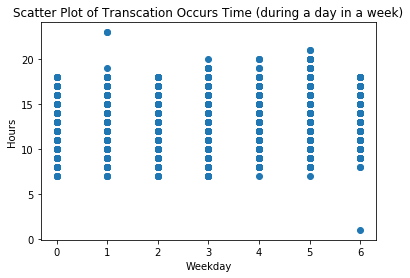

In [30]:
plt.scatter(df['Weekday'],df['Hours'])
plt.xlabel("Weekday")
plt.ylabel("Hours")
plt.title("Scatter Plot of Transcation Occurs Time (during a day in a week)")
plt.show()

> 發現有凌晨1點與晚上11點的交易各1筆，刪除兩個資料點

In [31]:
df = df.drop(df[df.Hours == 23].index)
df = df.drop(df[df.Hours == 1].index)
df.describe()

,TransactionID,Year,Month,Day,Week,Weekday,Hours
count,18977.000000,18977.000000,18977.000000,18977.000000,18977.000000,18977.000000,18977.000000
mean,4800.716235,2016.590346,5.893872,15.427149,23.586289,3.366127,12.273015
std,2598.007961,0.491783,4.663533,8.644771,20.138597,1.939566,2.324358
min,178.000000,2016.000000,1.000000,1.000000,1.000000,0.000000,7.000000
25%,2547.000000,2016.000000,2.000000,8.000000,6.000000,2.000000,10.000000
50%,4943.000000,2017.000000,3.000000,15.000000,11.000000,4.000000,12.000000
75%,7034.000000,2017.000000,11.000000,23.000000,46.000000,5.000000,14.000000
max,9158.000000,2017.000000,12.000000,31.000000,52.000000,6.000000,21.000000


In [32]:
print("資料總數：",df.shape[0],"\n資料欄數：",df.shape[1]) 

資料總數： 18977 
資料欄數： 11


---

# IV 資料視覺化

### 顧客在麵包店一次大概購買多少物品
> 平均單筆訂單的消費數量

In [33]:
itemsdf = df.groupby(['TransactionID'],as_index=False)['Item'].count()
itemsdf = itemsdf.sort_values(ascending=True, by=['TransactionID'])
display(itemsdf.head(5),itemsdf.Item.mean())

,TransactionID,Item
0,178,2
1,179,2
2,180,2
3,181,2
4,182,3


2.1621282898484675

> 平均會買兩個商品

---

### 什麼產品最熱銷
> 什麼產品是大家買的特別多的呢？ 這裡定義**熱門為銷售數量最高的15項商品**

In [34]:
#pd.value_counts(df.Item).head(10)
value_counts = df['Item'].value_counts(dropna=True, sort=True)
item_df = value_counts.rename_axis('Item').reset_index(name='Amounts')
top10item_df = item_df.head(15)
top10item_df

,Item,Amounts
0,coffee,5088
1,bread,3096
2,tea,1331
3,cake,947
4,pastry,796
5,sandwich,711
6,medialuna,592
7,hot chocolate,572
8,cookies,491
9,brownie,368


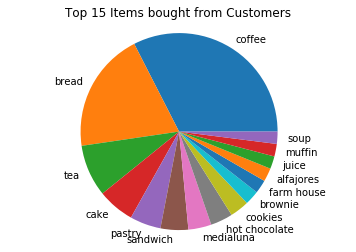

In [35]:
plt.pie(top10item_df.Amounts, labels=top10item_df.Item)
plt.axis("equal")
plt.title("Top 15 Items bought from Customers")
plt.show()

---

### 顧客光顧時間分布
#### 以整個禮拜來說
> **週六**的交易量是最多的，再來是週五  

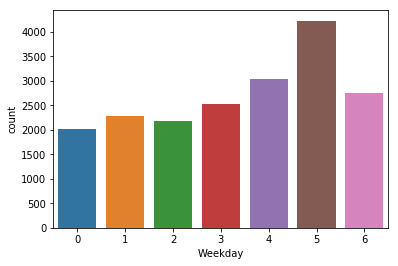

In [36]:
sns.countplot(x='Weekday',data=df)

#### 顧客的消費時間
> 每天消費時間從早上7點(應該是起床上班或上學的早餐)，到晚上6-8點(下班或下課肚子餓的晚餐)  
> 禮拜六交易結束時間有比較晚  
> 週日的交易起始時間比較晚   
> 店家一般營業時間應該是7點到8點，周六營業到9點，周日早上8點開門

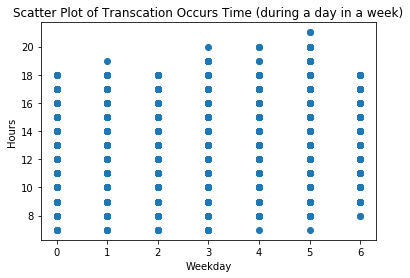

In [38]:
plt.scatter(df['Weekday'],df['Hours'])
plt.xlabel("Weekday")
plt.ylabel("Hours")
plt.title("Scatter Plot of Transcation Occurs Time (during a day in a week)")
plt.show()

#### 以一天來說
> 消費高峰是在上午11-12點  
> 消費低峰是在晚上6點過後  
> 晚上8點之後幾乎沒有交易，推測麵包店應該是打烊了

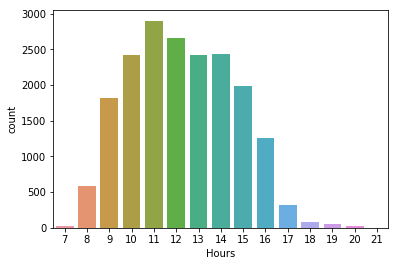

In [39]:
sns.countplot(x='Hours',data=df)

### 尖峰時刻 (11-12點) 的前15大消費商品

In [40]:
peak_df = df[(df.Hours <=12)&(df.Hours >= 11)] # 限制式11-12點
display(peak_df.head().head(10))

,Datetime,TransactionID,Item,Date,Time,Year,Month,Day,Week,Weekday,Hours
28,2016-11-01 11:00:48,193,coffee,2016/11/1,11:00:48,2016,11,1,44,1,11
29,2016-11-01 11:04:36,194,bread,2016/11/1,11:04:36,2016,11,1,44,1,11
30,2016-11-01 11:04:36,194,bread,2016/11/1,11:04:36,2016,11,1,44,1,11
31,2016-11-01 11:06:09,195,bread,2016/11/1,11:06:09,2016,11,1,44,1,11
32,2016-11-01 11:06:09,195,scandinavian,2016/11/1,11:06:09,2016,11,1,44,1,11


In [41]:
#pd.value_counts(peak_df.Item).head(10)
value_counts = peak_df['Item'].value_counts(dropna=True, sort=True)
peak_item_df = value_counts.rename_axis('Item').reset_index(name='peak_Amounts')
peaktop10item_df = peak_item_df.head(15)
peaktop10item_df

,Item,peak_Amounts
0,coffee,1578
1,bread,940
2,tea,328
3,cake,246
4,pastry,238
5,sandwich,202
6,medialuna,159
7,hot chocolate,145
8,cookies,134
9,farm house,125


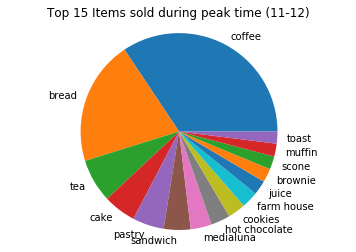

In [42]:
plt.pie(peaktop10item_df.peak_Amounts, labels=peaktop10item_df.Item)
plt.axis("equal")
plt.title("Top 15 Items sold during peak time (11-12)")
plt.show()

> 比較發現，尖峰時刻所購買的前15大商品，與總銷售的15大熱銷品項幾乎沒有不同

## 購物籃分析 (Apriori Algorithm)

想法：我想藉由one hot encoding轉換資料表後，進一步做關聯分析，只要有購買的產品就標註為1  
資料表處理流程：
1. 先將所有產品項目提取成欄位
2. 合併相同交易ID的訂單：做數值合併 (若該筆訂單買兩個一樣的物品，該物品的值就為2)
3. 將數值對應到0或1，0代表無購買，1代表有購買

> 將產品全部提取出來變成欄位，令交易ID為Index，接著進行交易ID的合併  
> 我們不採用get dummies因為她會把全部欄位轉換

In [43]:
one_hot_encoding = df.groupby(['TransactionID', 'Item'])['Item'].count().unstack().reset_index().fillna(0).set_index('TransactionID')
one_hot_encoding.head()

Item,afternoon with the baker,alfajores,argentina night,art tray,bacon,baguette,bakewell,bare popcorn,basket,bowl nic pitt,...,the bart,the nomad,tiffin,toast,truffles,tshirt,valentine's card,vegan feast,vegan mincepie,victorian sponge
TransactionID,,,,,,,,,,,,,,,,,,,,,
178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> 定義一個由行列對所有元素的操作函數，將數值maping到0或1；0代表此交易沒有購買這項產品，1代表有購買且數量可能是1個或多個

In [44]:
def encode(element):
    if element <= 0:
        return 0
    if element >= 1:
        return 1
one_hot_encoding = one_hot_encoding.applymap(encode)

In [45]:
one_hot_encoding.head()

Item,afternoon with the baker,alfajores,argentina night,art tray,bacon,baguette,bakewell,bare popcorn,basket,bowl nic pitt,...,the bart,the nomad,tiffin,toast,truffles,tshirt,valentine's card,vegan feast,vegan mincepie,victorian sponge
TransactionID,,,,,,,,,,,,,,,,,,,,,
178,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
180,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
181,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
182,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


> 我們僅留下在所有交易裡，出現至少1%次的{產品組合}，最小支持度設為0.01

In [46]:
buyingsets = apriori(one_hot_encoding, min_support=0.01, use_colnames=True) #use_colnames代入item的名稱
buyingsets.head()

,support,itemsets
0,0.036573,(alfajores)
1,0.016065,(baguette)
2,0.328358,(bread)
3,0.041928,(brownie)
4,0.103680,(cake)


In [47]:
print("高於1%的產品組合：",buyingsets.shape[0])

高於1%的產品組合： 60


---

### 我們想知道顧客購買某項產品之後，會怎麼影像到購買另外一種產品

> * metric：有：support、confidence、lift、leverage、conviction  
> * min_threshold：搭配以上使用  
>     * metric = 'support'  => 取值範圍 [0,1]  
>     * metric = 'confidence'  => 取值範圍 [0,1]  
>     * metric = 'lift'  => 取值範圍 [0, inf]  

### 設立關聯規則，衡量標準用confidence，與最小閾值為0.5 
> 顧客購買A之後購買B的可能性有多大

In [48]:
rules = association_rules(buyingsets, metric='confidence', min_threshold=0.5)
rules.sort_values(ascending=False, by=['confidence']) #信心由高到低

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
10,(toast),(coffee),0.033725,0.478637,0.023356,0.692568,1.446957,0.007215,1.695861
9,(spanish brunch),(coffee),0.017660,0.478637,0.010596,0.600000,1.253559,0.002143,1.303407
5,(medialuna),(coffee),0.063917,0.478637,0.035889,0.561497,1.173116,0.005296,1.188961
6,(pastry),(coffee),0.086362,0.478637,0.047511,0.550132,1.149371,0.006174,1.158923
0,(alfajores),(coffee),0.036573,0.478637,0.019938,0.545171,1.139007,0.002433,1.146284
7,(sandwich),(coffee),0.071437,0.478637,0.038054,0.532695,1.112942,0.003862,1.115680
4,(juice),(coffee),0.036459,0.478637,0.019369,0.531250,1.109922,0.001918,1.112240
1,(cake),(coffee),0.103680,0.478637,0.054574,0.526374,1.099734,0.004949,1.100789
8,(scone),(coffee),0.035320,0.478637,0.018457,0.522581,1.091809,0.001552,1.092043
2,(cookies),(coffee),0.053207,0.478637,0.027686,0.520343,1.087133,0.002219,1.086948


In [49]:
rules.shape[0]

11

### 設立關聯規則，衡量標準用lift，與最小閾值為1
> 商品A對商品B出現的可能性有沒有提升作用

In [50]:
rules = association_rules(buyingsets, metric='lift', min_threshold=1)
rules.sort_values(ascending=False, by=['lift']).head(10) #lift由高到低

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
41,(cake),"(coffee, tea)",0.103680,0.049447,0.010026,0.096703,1.955679,0.004899,1.052315
38,"(coffee, tea)",(cake),0.049447,0.103680,0.010026,0.202765,1.955679,0.004899,1.124286
8,(hot chocolate),(cake),0.060955,0.103680,0.011621,0.190654,1.838870,0.005301,1.107462
9,(cake),(hot chocolate),0.103680,0.060955,0.011621,0.112088,1.838870,0.005301,1.057588
11,(cake),(tea),0.103680,0.142190,0.024040,0.231868,1.630694,0.009298,1.116749
10,(tea),(cake),0.142190,0.103680,0.024040,0.169071,1.630694,0.009298,1.078696
37,(pastry),"(coffee, bread)",0.086362,0.089438,0.011279,0.130607,1.460301,0.003555,1.047353
36,"(coffee, bread)",(pastry),0.089438,0.086362,0.011279,0.126115,1.460301,0.003555,1.045489
30,(coffee),(toast),0.478637,0.033725,0.023356,0.048798,1.446957,0.007215,1.015847
31,(toast),(coffee),0.033725,0.478637,0.023356,0.692568,1.446957,0.007215,1.695861


In [51]:
rules.shape[0]

42

### 提升度與信心都大於50%

In [53]:
bothrules = rules[ (rules['lift'] >= 1) & (rules['confidence'] >= 0.5)]
bothrules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(alfajores),(coffee),0.036573,0.478637,0.019938,0.545171,1.139007,0.002433,1.146284
7,(cake),(coffee),0.103680,0.478637,0.054574,0.526374,1.099734,0.004949,1.100789
13,(cookies),(coffee),0.053207,0.478637,0.027686,0.520343,1.087133,0.002219,1.086948
14,(hot chocolate),(coffee),0.060955,0.478637,0.030990,0.508411,1.062205,0.001815,1.060567
17,(juice),(coffee),0.036459,0.478637,0.019369,0.531250,1.109922,0.001918,1.112240
19,(medialuna),(coffee),0.063917,0.478637,0.035889,0.561497,1.173116,0.005296,1.188961
23,(pastry),(coffee),0.086362,0.478637,0.047511,0.550132,1.149371,0.006174,1.158923
25,(sandwich),(coffee),0.071437,0.478637,0.038054,0.532695,1.112942,0.003862,1.115680
26,(scone),(coffee),0.035320,0.478637,0.018457,0.522581,1.091809,0.001552,1.092043
29,(spanish brunch),(coffee),0.017660,0.478637,0.010596,0.600000,1.253559,0.002143,1.303407


In [55]:
bothrules.shape[0]

11

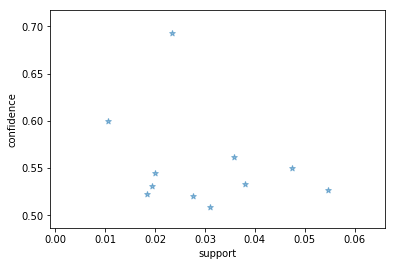

In [56]:
support = bothrules['support']
confidence = bothrules['confidence']
plt.scatter(support, confidence, alpha=0.5, marker="*")
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

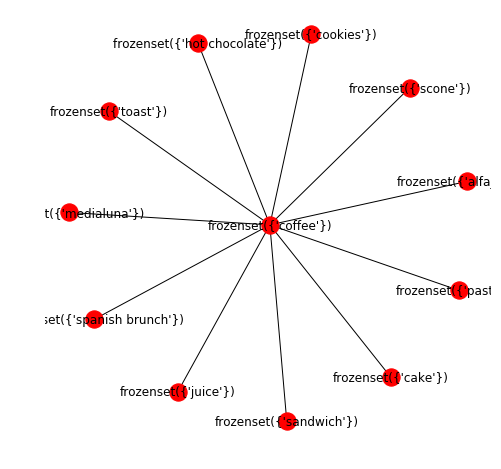

In [57]:
import networkx as nx
fig, ax=plt.subplots(figsize=(8,8))
GA=nx.from_pandas_edgelist(bothrules,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True)
plt.show()

### 找出提升度與信心都大於50%的前三名

In [58]:
display(bothrules.sort_values(ascending=False, by=['lift']).head(3),bothrules.sort_values(ascending=False, by=['confidence']).head(3))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
31,(toast),(coffee),0.033725,0.478637,0.023356,0.692568,1.446957,0.007215,1.695861
29,(spanish brunch),(coffee),0.017660,0.478637,0.010596,0.600000,1.253559,0.002143,1.303407
19,(medialuna),(coffee),0.063917,0.478637,0.035889,0.561497,1.173116,0.005296,1.188961


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
31,(toast),(coffee),0.033725,0.478637,0.023356,0.692568,1.446957,0.007215,1.695861
29,(spanish brunch),(coffee),0.017660,0.478637,0.010596,0.600000,1.253559,0.002143,1.303407
19,(medialuna),(coffee),0.063917,0.478637,0.035889,0.561497,1.173116,0.005296,1.188961


> **吐司(toast)、西班牙早午餐(spanish brunch)、牛角麵包(medialuna)**

## 我們發現

* 符合信心和提升度都大於50%的品項中，對應後者全部都是**咖啡(coffee)**
* 吐司(toast)、西班牙早午餐(spanish brunch)、牛角麵包(medialuna)三者都不是熱銷前5的商品
* 牛角麵包大約熱銷第7名，吐司熱銷第15但不是尖峰時刻的熱銷商品，西班牙早午餐根本沒上榜

---

# V 進一部探討這三個商品
> 吐司(toast)、西班牙早午餐(spanish brunch)、牛角麵包(medialuna)的消費時間分布

### 吐司(toast)

9     62
10    58
11    51
12    40
13    22
Name: Hours, dtype: int64


Text(0.5,1,'Peak of Toast')

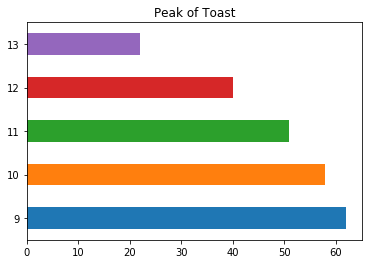

In [62]:
ddf = df[["Item","Hours"]]
toast_df = ddf[ddf['Item'].isin(['toast'])] # 留下toast的消費時間資料
toast_df['Hours'].value_counts().head(5).plot(kind="barh")
print(toast_df['Hours'].value_counts().head(5))
plt.title("Peak of Toast")

### 西班牙早午餐(spanish brunch)

13    32
14    29
12    29
11    20
15    19
Name: Hours, dtype: int64


Text(0.5,1,'Peak of Spanish Brunch')

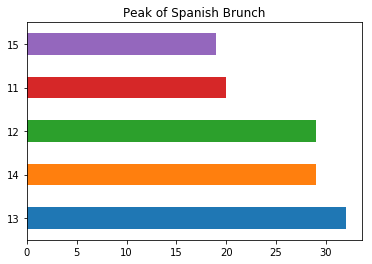

In [63]:
spanish_brunch_df = ddf[ddf['Item'].isin(['spanish brunch'])] # 留下spanish brunch的消費時間資料
spanish_brunch_df['Hours'].value_counts().head(5).plot(kind="barh")
print(spanish_brunch_df['Hours'].value_counts().head(5))
plt.title("Peak of Spanish Brunch")

### 牛角麵包(medialuna)

9     117
10    114
11    107
12     52
14     46
Name: Hours, dtype: int64


Text(0.5,1,'Peak of Medialuna')

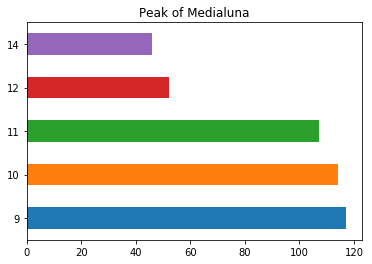

In [64]:
medialuna_df = ddf[ddf['Item'].isin(['medialuna'])] # 留下medialuna的消費時間資料
medialuna_df['Hours'].value_counts().head(5).plot(kind="barh")
print(medialuna_df['Hours'].value_counts().head(5))
plt.title("Peak of Medialuna")

### 我們發現
> 吐司(toast)：幾乎是作為**早餐**的選擇  
> 西班牙早午餐(spanish brunch)：幾乎是作為**午餐或下午茶**的選擇  
> 牛角麵包(medialuna)：幾乎是作為**早餐或午餐**的選擇  